## 7 DESCRIPTIVE STATISTICS

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as dates
import summarize_results as sr

### 7.1 NUMBER OF MATCHES BY GAME MODE

In [2]:
# The parquet file 'team_matches' has 1,022,520 unique team match IDs and their game modes.
team_matches = spark.read.parquet("s3://social-research-cheating/general-stats/teamplay_game_modes.parquet")
team_matches.registerTempTable("team_matches")

num_of_squad_matches = spark.sql("""SELECT COUNT(*) AS num_of_squad_matches FROM team_matches 
                                    WHERE mod = 'squad' OR mod = 'normal-squad' OR mod = 'normal-squad-fpp'""")
num_of_squad_matches.show()

num_of_duo_matches = spark.sql("""SELECT COUNT(*) AS num_of_duo_matches FROM team_matches 
                                  WHERE mod = 'duo' OR mod = 'normal-duo' OR mod = 'normal-duo-fpp'""")
num_of_duo_matches.show()

+--------------------+
|num_of_squad_matches|
+--------------------+
|              662650|
+--------------------+

+------------------+
|num_of_duo_matches|
+------------------+
|            359870|
+------------------+



In [4]:
other_modes = spark.sql("SELECT * FROM team_matches WHERE mod != 'squad' AND mod != 'duo'")
other_modes.registerTempTable("other_modes")

summary_table = spark.sql("""SELECT mod AS mode, COUNT(mid) AS num_of_matches 
                             FROM other_modes GROUP BY mod""")
summary_table.show()

+----------------+--------------+
|            mode|num_of_matches|
+----------------+--------------+
|      normal-duo|          2299|
|normal-squad-fpp|           350|
|  normal-duo-fpp|           118|
|    normal-squad|          4032|
+----------------+--------------+



### 7.2 NUMBER OF MATCHES WITH CHEATERS BY GAME MODE

In [3]:
td = spark.read.parquet("s3://social-research-cheating/raw_td.parquet")
td.registerTempTable("td")

nodes = spark.read.parquet("s3://social-research-cheating/nodes.parquet")
nodes.registerTempTable("nodes")

In [5]:
add_killer_flags = spark.sql("""SELECT mid, src, start_date AS src_sd, ban_date AS src_bd, 
                                cheating_flag AS src_flag, 
                                CASE WHEN m_date <= ban_date AND m_date >= start_date THEN 1 ELSE 0 END 
                                AS src_curr_flag, dst, time, m_date 
                                FROM td t LEFT JOIN players p ON t.src = p.id""")
add_killer_flags.registerTempTable("add_killer_flags")
    
edges = spark.sql("""SELECT mid, src, src_sd, src_bd, src_flag, src_curr_flag,
                     dst, start_date AS dst_sd, ban_date AS dst_bd, cheating_flag AS dst_flag, 
                     CASE WHEN m_date <= ban_date AND m_date >= start_date THEN 1 ELSE 0 END 
                     AS dst_curr_flag, time, m_date 
                     FROM add_killer_flags a LEFT JOIN players p ON a.dst = p.id""")
edges.registerTempTable("edges")

cheating_killers = spark.sql("""SELECT DISTINCT mid, src AS pid, src_curr_flag   
                                FROM edges WHERE src_curr_flag = 1""")
cheating_victims = spark.sql("""SELECT DISTINCT mid, dst, dst_curr_flag   
                                FROM edges WHERE dst_curr_flag = 1""")
cheating_killers.registerTempTable("cheating_killers")
cheating_victims.registerTempTable("cheating_victims")

cheaters = spark.sql("SELECT * FROM cheating_killers UNION SELECT * FROM cheating_victims")
cheaters.registerTempTable("cheaters")

summary_table = spark.sql("""SELECT mid, COUNT(DISTINCT pid) AS num_of_cheaters 
                             FROM cheaters GROUP BY mid""")
# summary_table.write.parquet("s3://social-research-cheating/general-stats/sum_tab.parquet")

In [12]:
num_of_cheaters_per_match = spark.read.parquet("s3://social-research-cheating/general-stats/sum_tab.parquet")
num_of_cheaters_per_match.registerTempTable("num_of_cheaters_per_match")
num_of_cheaters_per_match.show(10)

+--------------------+-----+
|                 mid|c_cnt|
+--------------------+-----+
|81771843-5753-47a...|    1|
|38fd82a6-1343-40c...|    1|
|d305bba6-8662-430...|    4|
|3d8da5e8-bedf-4fa...|    2|
|ab8b3d82-8dc3-4b5...|    2|
|5357f999-1126-48a...|    1|
|e7dcbed7-0190-4bf...|    1|
|17b49e2e-5532-4c8...|    1|
|9e4cf53c-8ae9-42c...|    1|
|462ed4d4-0c54-4b9...|    1|
+--------------------+-----+
only showing top 10 rows



In [13]:
team_matches = spark.read.parquet("s3://social-research-cheating/general-stats/teamplay_game_modes.parquet")
team_matches.registerTempTable("team_matches")

add_mods = spark.sql("""SELECT n.mid, c_cnt, CASE WHEN mod IS NULL THEN 'NA' ELSE mod END AS mod 
                        FROM num_of_cheaters_per_match n LEFT JOIN team_matches t ON n.mid = t.mid""")
add_mods.write.parquet("s3://social-research-cheating/general-stats/num_of_cheaters_per_match.parquet")

In [14]:
add_mods = spark.read.parquet("s3://social-research-cheating/general-stats/num_of_cheaters_per_match.parquet")
add_mods.registerTempTable("add_mods")
add_mods.show(10)

+--------------------+-----+-----+
|                 mid|c_cnt|  mod|
+--------------------+-----+-----+
|002033f0-face-44e...|    1|   NA|
|002589bf-c5c1-411...|    1|  duo|
|0117177b-4a55-40d...|    1|squad|
|01198b04-0c5d-4ef...|    2|squad|
|0121d461-69d9-4ef...|    2|  duo|
|016920f2-d4dc-4ae...|    1|squad|
|020a98c5-eb18-493...|    1|squad|
|031ac8b1-9f1e-435...|    2|squad|
|03777616-f101-482...|    1|   NA|
|03e0772c-3c13-40d...|    1|squad|
+--------------------+-----+-----+
only showing top 10 rows



In [17]:
num_of_cheaters_in_solo = spark.sql("""SELECT c_cnt, COUNT(mid) FROM add_mods WHERE mod = 'NA' 
                                       GROUP BY c_cnt ORDER BY c_cnt""")
num_of_cheaters_in_solo.show()

num_of_cheaters_in_squad = spark.sql("""SELECT c_cnt, COUNT(mid) FROM add_mods 
                                        WHERE mod = 'squad' OR mod = 'normal-squad' OR mod = 'normal-squad-fpp' 
                                        GROUP BY c_cnt ORDER BY c_cnt""")
num_of_cheaters_in_squad.show()

num_of_cheaters_in_duo = spark.sql("""SELECT c_cnt, COUNT(mid) FROM add_mods 
                                      WHERE mod = 'duo' OR mod = 'normal-duo' OR mod = 'normal-duo-fpp' 
                                      GROUP BY c_cnt ORDER BY c_cnt""")
num_of_cheaters_in_duo.show()

+-----+----------+
|c_cnt|count(mid)|
+-----+----------+
|    1|     10265|
|    2|       951|
|    3|        77|
|    4|         3|
+-----+----------+

+-----+----------+
|c_cnt|count(mid)|
+-----+----------+
|    1|     64095|
|    2|      9079|
|    3|      1355|
|    4|       212|
|    5|        27|
|    6|         4|
+-----+----------+

+-----+----------+
|c_cnt|count(mid)|
+-----+----------+
|    1|     19195|
|    2|      1730|
|    3|       135|
|    4|        11|
+-----+----------+



### 7.3 NUMBER OF PLAYERS WITH AT LEAST ONE VICTIMIZATION EXPERIENCE

In [30]:
victims = spark.sql("SELECT COUNT(DISTINCT dst) FROM edges WHERE src_curr_flag = 1")
victims.show()

+-------------------+
|count(DISTINCT dst)|
+-------------------+
|             287342|
+-------------------+



### 7.4 NUMBER OF UNIQUE PLAYERS

In [6]:
killers = spark.sql("SELECT src FROM td")
killers.registerTempTable("killers")

victims = spark.sql("SELECT dst FROM td")
victims.registerTempTable("victims")

unique_players = spark.sql("SELECT src AS id FROM killers UNION SELECT * FROM victims")
print(unique_players.count())
unique_players.write.parquet("s3://social-research-cheating/general-stats/unique_players.parquet")

1975877


### 7.5 NUMBER OF DAYS PLAYERS ACCESSED THE GAME

In [5]:
killers = spark.read.parquet("s3://social-research-cheating/general-stats/killers.parquet")
killers.registerTempTable("killers")

victims = spark.read.parquet("s3://social-research-cheating/general-stats/victims.parquet")
victims.registerTempTable("victims")

merged_table = spark.sql("SELECT src AS id, m_date FROM killers UNION SELECT * FROM victims")
merged_table.registerTempTable("merged_table")

days = spark.sql("SELECT id, COUNT(*) AS days FROM merged_table GROUP BY id")
days.write.parquet("s3://social-research-cheating/general-stats/num_of_days.parquet")
days_df = days.toPandas()
days_df.to_csv('num_of_days.csv', index=False)

In [4]:
days = pd.read_csv("data/general_stats/num_of_days.csv")

print(round(days['days'].mean(), 3))
print(days['days'].median())

5.767
3.0


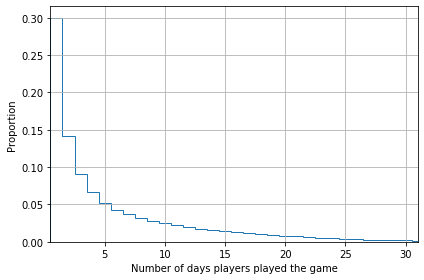

In [5]:
bins = np.arange(0, days['days'].max() + 1.5) - 0.5
fig, ax = plt.subplots()
days.hist(ax=ax, column='days', histtype='step', bins=bins, 
          weights=np.zeros_like(days['days']) + 1. / len(days['days']))
plt.xlim(xmin=0.5)
plt.xlim(xmax=31)
plt.xlabel("Number of days players played the game")
plt.ylabel("Proportion")
plt.title("")
plt.tight_layout()
plt.show()

### 7.6 NUMBER OF MATCHES BY DATE

In [31]:
DATA_PATH = "s3://social-research-cheating/general-stats/mids_by_date.parquet"
matches_by_date = spark.read.parquet(DATA_PATH)
matches_by_date_df = matches_by_date.toPandas()
matches_by_date_df.to_csv('mids_by_date.csv', index=False)

In [11]:
matches_by_date = pd.read_csv("data/general_stats/mids_by_date.csv")

matches_by_date['m_date'] = pd.to_datetime(matches_by_date['m_date'], format='%Y-%m-%d')
matches_by_date['day'] = matches_by_date['m_date'].dt.dayofweek
days = {0: 'M', 1: 'T', 2: 'W', 3: 'T', 4: 'F', 5: 'S', 6: 'S'}
matches_by_date['day'] = matches_by_date['day'].apply(lambda x: days[x])

matches_by_date = matches_by_date.sort_values(['m_date'])
matches_by_date.set_index(['m_date'], inplace=True)

print(matches_by_date)
print(matches_by_date['num_of_mids'].sum())

            num_of_mids day
m_date                     
2019-03-01        48886   F
2019-03-02        48995   S
2019-03-03        45696   S
2019-03-04        33555   M
2019-03-05        30504   T
2019-03-06        30434   W
2019-03-07        31267   T
2019-03-08        36469   F
2019-03-09        50479   S
2019-03-10        46290   S
2019-03-11        29363   M
2019-03-12        29157   T
2019-03-13        29009   W
2019-03-14        29890   T
2019-03-15        37090   F
2019-03-16        50550   S
2019-03-17        45816   S
2019-03-18        29833   M
2019-03-19        29523   T
2019-03-20        29240   W
2019-03-21        31193   T
2019-03-22        36154   F
2019-03-23        50375   S
2019-03-24        45624   S
2019-03-25        29115   M
2019-03-26        27491   T
2019-03-27        29446   W
2019-03-28        24271   T
2019-03-29        36189   F
2019-03-30        49550   S
2019-03-31        45487   S
1146941


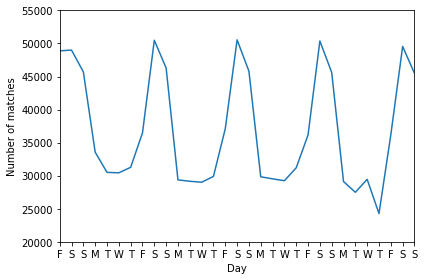

In [8]:
fig, ax = plt.subplots()
matches_by_date.plot(ax=ax)
plt.xticks(matches_by_date.index, matches_by_date["day"].values)
ax.get_legend().remove()
plt.ylim(ymin=20000, ymax=55000)
plt.xlabel("Day")
plt.ylabel("Number of matches")
plt.tight_layout()
plt.show()

### 7.7 NUMBER OF CHEATERS BY BAN DATE

In [10]:
num_of_cheaters = pd.read_csv("data/general_stats/num_of_cheaters.csv")
num_of_cheaters['ban_date'] = pd.to_datetime(num_of_cheaters['ban_date'], format='%Y-%m-%d')
num_of_cheaters = num_of_cheaters.sort_values(['ban_date'])
num_of_cheaters.set_index(['ban_date'], inplace=True)

print(num_of_cheaters)
print(num_of_cheaters['num_of_cheaters'].sum())

            num_of_cheaters
ban_date                   
2019-03-01              103
2019-03-02              290
2019-03-03              258
2019-03-04              312
2019-03-05              228
2019-03-06              702
2019-03-07              262
2019-03-08              145
2019-03-09              690
2019-03-10              135
2019-03-11              511
2019-03-12              324
2019-03-13              188
2019-03-14              139
2019-03-15              132
2019-03-16              107
2019-03-17              144
2019-03-19              116
2019-03-20              112
2019-03-21              105
2019-03-22              118
2019-03-23              176
2019-03-24               99
2019-03-25               89
2019-03-26              170
2019-03-27              111
2019-03-28               99
2019-03-29              114
2019-03-30               93
2019-03-31               89
6161


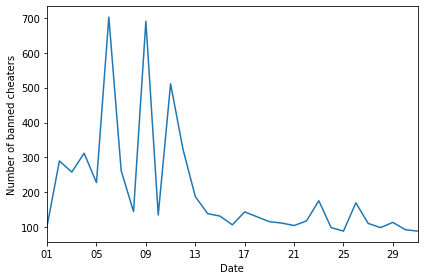

In [17]:
fig, ax = plt.subplots()
num_of_cheaters.plot(ax=ax)
ax.get_legend().remove()
ax.xaxis.set_major_formatter(dates.DateFormatter('%d'))
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center')
plt.xlabel("Date")
plt.ylabel("Number of banned cheaters")
plt.tight_layout()
plt.show() 

### 7.8 SUCCESS RATES OF PLAYERS

In [3]:
# Use the matches where at least one cheater played.
matches_with_cheaters = spark.read.parquet("s3://social-research-cheating/general-stats/matches_with_cheaters.parquet")
matches_with_cheaters.registerTempTable("matches_with_cheaters")

add_killer_flags = spark.sql("""SELECT mid, src, 
                                CASE WHEN m_date <= ban_date AND m_date >= start_date THEN 1 ELSE 0 END 
                                AS src_curr_flag, dst, time, m_date, mod 
                                FROM matches_with_cheaters m LEFT JOIN nodes n ON m.src = n.id""")
add_killer_flags.registerTempTable("add_killer_flags")

edges = spark.sql("""SELECT mid, src, src_curr_flag, dst, 
                     CASE WHEN m_date <= ban_date AND m_date >= start_date THEN 1 ELSE 0 END AS dst_curr_flag,
                     time, m_date, mod 
                     FROM add_killer_flags a LEFT JOIN nodes n ON a.dst = n.id""")
edges.registerTempTable("edges")

### WIN RATES IN SOLO MATCHES

In [10]:
solo_matches = spark.sql("""SELECT e.*, ROW_NUMBER() OVER (PARTITION BY mid ORDER BY time DESC) AS row_number 
                            FROM edges e WHERE mod = 'NA'""")
solo_matches.registerTempTable("solo_matches")

participants = spark.sql("""SELECT mid, src AS id, src_curr_flag AS is_cheating_now FROM solo_matches 
                            UNION SELECT mid, dst, dst_curr_flag FROM solo_matches""")
participants.registerTempTable("participants")

summary_tab = spark.sql("""SELECT is_cheating_now, COUNT(*) AS num_of_players 
                           FROM participants GROUP BY is_cheating_now ORDER BY is_cheating_now""")
summary_tab.show()

+---------------+--------------+
|is_cheating_now|num_of_players|
+---------------+--------------+
|              0|       1049113|
|              1|         12410|
+---------------+--------------+



In [6]:
winners = spark.sql("""SELECT mid, src AS winner, src_curr_flag AS is_cheating_now 
                       FROM solo_matches WHERE row_number = 1""")
winners.registerTempTable("winners")
winners.show(5)

summary_tab = spark.sql("""SELECT is_cheating_now, COUNT(*) AS num_of_winners 
                           FROM winners GROUP BY is_cheating_now ORDER BY is_cheating_now""")
summary_tab.show()

+--------------------+--------------------+---------------+
|                 mid|              winner|is_cheating_now|
+--------------------+--------------------+---------------+
|2c8acf5b-b768-433...|account.f5fbb648e...|              0|
|2da69df9-d18a-472...|account.016d386c9...|              0|
|2ebc4752-2e5d-419...|account.9e0b10ae1...|              0|
|32514c85-ac8c-43d...|account.f043216c1...|              0|
|32bc7f14-27a0-497...|account.601c100a4...|              0|
+--------------------+--------------------+---------------+
only showing top 5 rows

+---------------+--------------+
|is_cheating_now|num_of_winners|
+---------------+--------------+
|              0|          9621|
|              1|          1675|
+---------------+--------------+



### GETTING INTO THE TOP 30% IN SOLO MATCHES

In [9]:
solo_matches.registerTempTable("td")

data_with_damage = sr.add_damage(solo_matches, 30)
data_with_damage.registerTempTable("data_with_damage")

good_performers = spark.sql("""SELECT DISTINCT mid, dst, dst_curr_flag AS is_cheating_now 
                               FROM data_with_damage WHERE damage = 1""")
good_performers.registerTempTable("good_performers")

top_30_players = spark.sql("SELECT * FROM winners UNION SELECT * FROM good_performers")
top_30_players.registerTempTable("top_30_players")
top_30_players.show(5)

summary_tab = spark.sql("""SELECT is_cheating_now, COUNT(*) AS num_of_good_players FROM top_30_players 
                           GROUP BY is_cheating_now ORDER BY is_cheating_now""")
summary_tab.show()

+--------------------+--------------------+---------------+
|                 mid|              winner|is_cheating_now|
+--------------------+--------------------+---------------+
|ff8c960c-b37f-4df...|account.5bf6fc5e1...|              1|
|d6124174-6533-4d8...|account.0808fb8f4...|              0|
|22ad4af0-b75e-4e0...|account.d2c9cb567...|              0|
|a91ab075-e82a-4b6...|account.8930c639e...|              0|
|3826dd72-e76d-4e8...|account.dfd9e66b6...|              0|
+--------------------+--------------------+---------------+
only showing top 5 rows

+---------------+-------------------+
|is_cheating_now|num_of_good_players|
+---------------+-------------------+
|              0|             297261|
|              1|               5217|
+---------------+-------------------+



### WIN RATES OF TEAMS IN TEAM MATCHES

In [9]:
rank_data = spark.read.parquet("s3://social-research-cheating/edges/team_ranks.parquet")
rank_data.registerTempTable("rank_data")

# The parquet file below contains the team matches with team IDs.
team_match_edges = spark.read.parquet("s3://social-research-cheating/general-stats/match_logs_with_mods.parquet")
team_match_edges.registerTempTable("team_match_edges")

participants = spark.sql("""SELECT mid, src AS id, src_curr_flag AS is_cheating_now, src_tid AS tid 
                            FROM team_match_edges UNION 
                            SELECT mid, dst, dst_curr_flag, dst_tid FROM team_match_edges""")
participants.registerTempTable("participants")

num_of_cheaters_per_team = spark.sql("""SELECT mid, tid, SUM(is_cheating_now) AS num_of_cheaters 
                                        FROM participants WHERE tid != 'NA' GROUP BY mid, tid""")
num_of_cheaters_per_team.registerTempTable("num_of_cheaters_per_team")

summary_tab = spark.sql("""SELECT num_of_cheaters, COUNT(*) AS num_of_teams 
                           FROM num_of_cheaters_per_team GROUP BY num_of_cheaters 
                           ORDER BY num_of_cheaters""")
summary_tab.show()

+---------------+------------+
|num_of_cheaters|num_of_teams|
+---------------+------------+
|              0|     2807526|
|              1|       96747|
|              2|        4094|
|              3|         187|
|              4|          11|
+---------------+------------+



In [17]:
add_team_ranks = spark.sql("""SELECT n.mid, n.tid, n.num_of_cheaters, 
                              CASE WHEN r.rank IS NULL THEN 'NA' ELSE r.rank END AS rank 
                              FROM num_of_cheaters_per_team n LEFT JOIN rank_data r 
                              ON n.mid = r.mid AND n.tid = r.tid""")
add_team_ranks.registerTempTable("add_team_ranks")

winners = spark.sql("SELECT DISTINCT mid, tid FROM add_team_ranks WHERE rank = 1")
winners.registerTempTable("winners")

num_of_winners = spark.sql("""SELECT num_of_cheaters, 
                              COUNT(CASE WHEN rank = 1 THEN 1 ELSE NULL END) AS num_of_winners
                              FROM add_team_ranks GROUP BY num_of_cheaters 
                              ORDER BY num_of_cheaters""")
num_of_winners.show()

+---------------+--------------+
|num_of_cheaters|num_of_winners|
+---------------+--------------+
|              0|         79404|
|              1|         14517|
|              2|          1054|
|              3|            72|
|              4|             9|
+---------------+--------------+



### GETTING INTO THE TOP 30% - TEAMS IN TEAM MATCHES

In [13]:
team_match_edges.registerTempTable("td")
data_with_damage = sr.add_damage(team_match_edges, 30)
data_with_damage.registerTempTable("data_with_damage")

good_performers = spark.sql("""SELECT DISTINCT mid, dst_tid AS tid 
                               FROM data_with_damage WHERE damage = 1 AND dst_tid != 'NA'""")
good_performers.registerTempTable("good_performers")

top_30_players = spark.sql("SELECT * FROM winners UNION SELECT * FROM good_performers")
top_30_players.registerTempTable("top_30_players")

add_num_of_cheaters = spark.sql("""SELECT t.*, num_of_cheaters 
                                   FROM top_30_players t JOIN num_of_cheaters_per_team n 
                                   ON t.mid = n.mid AND t.tid = n.tid""")
add_num_of_cheaters.registerTempTable("add_num_of_cheaters")

summary_tab = spark.sql("""SELECT num_of_cheaters, COUNT(*) AS num_of_teams 
                           FROM add_num_of_cheaters GROUP BY num_of_cheaters
                           ORDER BY num_of_cheaters""")
summary_tab.show()

+---------------+------------+
|num_of_cheaters|num_of_teams|
+---------------+------------+
|              0|     1059217|
|              1|       52887|
|              2|        2475|
|              3|         129|
|              4|          10|
+---------------+------------+



### WIN RATES OF SINGLE PLAYERS IN TEAM MATCHES

In [20]:
single_players_in_team_matches = spark.sql("""SELECT DISTINCT mid, id, is_cheating_now 
                                              FROM participants WHERE tid = 'NA'""")
single_players_in_team_matches.registerTempTable("single_players_in_team_matches")

summary_tab = spark.sql("""SELECT is_cheating_now, COUNT(*) AS num_of_players 
                           FROM single_players_in_team_matches 
                           GROUP BY is_cheating_now ORDER BY is_cheating_now""")
summary_tab.show()

+---------------+--------------+
|is_cheating_now|num_of_players|
+---------------+--------------+
|              0|        143791|
|              1|          4889|
+---------------+--------------+



In [ ]:
team_match_edges = spark.read.parquet("s3://social-research-cheating/general-stats/match_logs_with_mods.parquet")
team_match_edges.registerTempTable("team_match_edges")

# The parquet file below contains the number of cheaters and rank of each team in team matches.
add_team_ranks = spark.read.parquet("s3://social-research-cheating/general-stats/add_team_ranks.parquet")
add_team_ranks.registerTempTable("add_team_ranks")

In [6]:
team_match_ids = spark.sql("SELECT DISTINCT mid FROM team_match_edges")
team_match_ids.registerTempTable("team_match_ids")

match_ids_with_winning_teams = spark.sql("SELECT DISTINCT mid FROM add_team_ranks WHERE rank = 1")
match_ids_with_winning_teams.registerTempTable("match_ids_with_winning_teams")

leftover_ids = spark.sql("SELECT * FROM team_match_ids MINUS SELECT * FROM match_ids_with_winning_teams")
leftover_ids.registerTempTable("leftover_ids")
print(leftover_ids.count())

787


In [13]:
team_matches_with_single_winners = spark.sql("""SELECT t.* FROM team_match_edges t JOIN leftover_ids l 
                                                ON t.mid = l.mid""")
team_matches_with_single_winners.registerTempTable("team_matches_with_single_winners")

add_row_nums = spark.sql("""SELECT t.*, 
                            ROW_NUMBER() OVER (PARTITION BY mid ORDER BY time DESC) AS row_number 
                            FROM team_matches_with_single_winners t""")
add_row_nums.registerTempTable("add_row_nums")

winners = spark.sql("""SELECT mid, src AS winner, src_curr_flag AS is_cheating_now, src_tid AS tid 
                       FROM add_row_nums WHERE row_number = 1""")
winners.registerTempTable("winners")

summary_tab = spark.sql("""SELECT is_cheating_now, COUNT(*) AS num_of_winners 
                           FROM winners GROUP BY is_cheating_now ORDER BY is_cheating_now""")
summary_tab.show()

+---------------+--------------+
|is_cheating_now|num_of_winners|
+---------------+--------------+
|              0|           391|
|              1|           396|
+---------------+--------------+



### GETTING INTO THE TOP 30% - SINGLE PLAYERS IN TEAM MATCHES

In [17]:
team_match_edges.registerTempTable("td")
data_with_damage = sr.add_damage(team_match_edges, 30)
data_with_damage.registerTempTable("data_with_damage")

good_performers = spark.sql("""SELECT DISTINCT mid, dst, dst_curr_flag AS is_cheating_now, dst_tid AS tid 
                               FROM data_with_damage WHERE damage = 1 AND dst_tid = 'NA'""")
good_performers.registerTempTable("good_performers")

top_30_players = spark.sql("SELECT * FROM winners UNION SELECT * FROM good_performers")
top_30_players.registerTempTable("top_30_players")
top_30_players.show(5)

summary_tab = spark.sql("""SELECT is_cheating_now, COUNT(*) AS num_of_good_players FROM top_30_players 
                           GROUP BY is_cheating_now ORDER BY is_cheating_now""")
summary_tab.show()

+--------------------+--------------------+---------------+---+
|                 mid|              winner|is_cheating_now|tid|
+--------------------+--------------------+---------------+---+
|01ab2e3c-2517-4f8...|account.71fe27201...|              0| NA|
|085922a5-2a5c-43c...|account.6768e32fd...|              0| NA|
|09bf294c-0e06-422...|account.036e8a1a7...|              0| NA|
|0a0cb7ee-2423-4ba...|account.9365dbfc4...|              0| NA|
|139c1fb2-4679-426...|account.b8840c4e6...|              0| NA|
+--------------------+--------------------+---------------+---+
only showing top 5 rows

+---------------+-------------------+
|is_cheating_now|num_of_good_players|
+---------------+-------------------+
|              0|              26730|
|              1|               1486|
+---------------+-------------------+



### 7.9 NUMBER OF PLAYERS WHO PLAYED WITH A CHEATER AT LEAST ONCE

In [6]:
matches_with_cheaters = spark.read.parquet("s3://social-research-cheating/general-stats/matches_with_cheaters.parquet")
matches_with_cheaters.registerTempTable("matches_with_cheaters")

add_killer_flags = spark.sql("""SELECT mid, src, 
                                CASE WHEN m_date <= ban_date AND m_date >= start_date THEN 1 ELSE 0 END 
                                AS src_curr_flag, dst, time, m_date, mod 
                                FROM matches_with_cheaters m LEFT JOIN nodes n ON m.src = n.id""")
add_killer_flags.registerTempTable("add_killer_flags")

edges = spark.sql("""SELECT mid, src, src_curr_flag, dst, 
                     CASE WHEN m_date <= ban_date AND m_date >= start_date THEN 1 ELSE 0 END 
                     AS dst_curr_flag, time, m_date, mod 
                     FROM add_killer_flags a LEFT JOIN nodes n ON a.dst = n.id""")
edges.registerTempTable("edges")

participants = spark.sql("""SELECT mid, src AS id, src_curr_flag AS is_cheating_now FROM edges 
                            UNION SELECT mid, dst, dst_curr_flag FROM edges""")
participants.registerTempTable("participants")

unique_non_cheaters = spark.sql("SELECT DISTINCT id FROM participants WHERE is_cheating_now = 0")
print(unique_non_cheaters.count())

1185279
